In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 50 #higher precision
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from plotDensity import *

In [2]:
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res


def free_energy(E_list, log_g_list,  T):
    #Need to log sum over g(E)*exp(-E/T) without overflow issues
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies


def process_results(batch_results,X,Y):
    rescaled_results = []
    for seed_results in batch_results:

        rescaled_seed_results = []
        for error_result in seed_results:

            walker_results = error_result
            walker_results = get_renormalized_log_g_values_as_dict_list(walker_results)
            walker_results = average_matching_keys(walker_results)
            results_x = []
            results_y = []
            for result in walker_results:
                results_y.append(np.array(list(result.values())))
                results_x.append(np.array(list(result.keys())))

            derivatives_wrt_e = get_derivative_wrt_e(walker_results)
            minimum_deviation_energies = find_lowest_inverse_temp_deviation(derivatives_wrt_e)
            rescale_results_for_concatenation(results_x, results_y, minimum_deviation_energies)

            x_max = -1 -2*X*Y
            rescaled_x = []
            rescaled_y = []
            for i in range(len(results_x)):
                for j in range(len(results_x[i])):
                    if results_x[i][j] > x_max: #avoid double counting
                        x_max = results_x[i][j]
                        rescaled_x.append(results_x[i][j])
                        rescaled_y.append(results_y[i][j])

            offset = log_sum_exp(rescaled_y)
            rescaled_y = [res + mp.log(2)*X*Y - offset for res in rescaled_y]
            rescaled_seed_results.append([rescaled_x,rescaled_y])
        rescaled_results.append(rescaled_seed_results)
    return rescaled_results


In [3]:
from PyMatching import *

num_shots = 200000
Ls = [4,6]
ps = [0.08,0.10,0.12]
#ps = np.linspace(0.01, 0.12, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [4]:
seed_runs = {
    "4": {
        "0.08":{
            "I": 1003,
            "X": 1000,
            "Y": 1001,
            "Z": 1002
        },
        "0.1":{
            "I": 1011,
            "X": 1008,
            "Y": 1009,
            "Z": 1010
        },
        "0.12":{
            "I": 1019,
            "X": 1016,
            "Y": 1017,
            "Z": 1018
        }
    },
    "6": {
        "0.08":{
            "I": 1007,
            "X": 1004,
            "Y": 1005,
            "Z": 1006
        },
        "0.1":{
            "I": 1015,
            "X": 1012,
            "Y": 1013,
            "Z": 1014
        },
        "0.12":{
            "I": 1023,
            "X": 1020,
            "Y": 1021,
            "Z": 1022
        }
    }
}

In [5]:
batch_results = []

probabilities = [0.08, 0.1, 0.12]

for p in probabilities:

    print('Probability',p)

    seed_range = range(1,251)

    batch_res_4 = []

    for seed in seed_range:

        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                seed_run = seed_runs["4"][str(p)][error]
                filename = "../results/periodic_old_handling/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_%d"%seed_run+"_alpha_0.800000_beta_0.0000010000exchange_offset50.txt"
                res.append(read_data_from_file(filename))

        except:
            print('One or more error classes at 4 by 4 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_4.append(res)

    batch_res_6 = []
    for seed in seed_range:

        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                seed_run = seed_runs["6"][str(p)][error]
                filename = "../results/periodic_old_handling/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_%d"%seed_run+"_alpha_0.800000_beta_0.0000010000exchange_offset50.txt"

                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 6 by 6 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_6.append(res)


    print('Adding to results for probability',p)
    print('Number of seeds:', len(batch_res_4), len(batch_res_6))
    rescaled_res_4 = process_results(batch_res_4, 4, 4)
    rescaled_res_6 = process_results(batch_res_6, 6, 6)
    batch_results.append([rescaled_res_4,rescaled_res_6])

Probability 0.08
Adding to results for probability 0.08
Number of seeds: 250 250
Probability 0.1
Adding to results for probability 0.1
Number of seeds: 250 250
Probability 0.12
Adding to results for probability 0.12
Number of seeds: 250 250


In [6]:
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = np.min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = np.min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

lowest_energies_batch = []
lowest_g_batch = []

for i, p in enumerate(probabilities):

    print('Probability',p)

    #would need a separate function for the p=0 case, and probably won't consider p=0.
    if len(batch_results)>=i+1 and p>0:

        lowest_energies_4 = get_lowest_energies(batch_results[i][0])
        lowest_energies_6 = get_lowest_energies(batch_results[i][1])
        lowest_energies_batch.append([lowest_energies_4,lowest_energies_6])

        lowest_g_4 = get_lowest_g(batch_results[i][0])
        lowest_g_6 = get_lowest_g(batch_results[i][1])
        lowest_g_batch.append([lowest_g_4,lowest_g_6])

        print('Number of seeds:', len(lowest_energies_4), len(lowest_energies_6))

Probability 0.08
Number of seeds: 250 250
Probability 0.1
Number of seeds: 250 250
Probability 0.12
Number of seeds: 250 250


In [7]:
free_energies_batch = []

for i, p in enumerate(probabilities):

    print('Probability',p)

    if p == 0:
        T_Nish = 0
    else:
        T_Nish = 1/(mp.log((1-p)/p)/2)

    temperatures = [1e-20,T_Nish,1e20]

    #would need a separate function for the p=0 case, and probably won't consider p=0.
    if len(batch_results)>=i+1 and p>0:

        free_energies_4 = get_free_energies(batch_results[i][0],temperatures)
        free_energies_6 = get_free_energies(batch_results[i][1],temperatures)
        free_energies_batch.append([free_energies_4,free_energies_6])
        print('Number of seeds:', len(free_energies_4), len(free_energies_6))

Probability 0.08
Number of seeds: 250 250
Probability 0.1
Number of seeds: 250 250
Probability 0.12
Number of seeds: 250 250


In [8]:
def experimental_fraction(f_class, j):

    #If condition determines if we are in the equivalence class the dedcoder chooses
    #The if condition uses the temperature under consideration
    #Meanwhile the ratios use the Nishimori temperature, with j=1 giving this by convention

    classes = [f_class[0][j],f_class[1][j],f_class[2][j],f_class[3][j]]

    i_max = classes.index(max(classes))

    i_others = [0,1,2,3]
    i_others.remove(i_max)

    #If we are in the largest class (the ``P(A)'' term)
    if i_max == 0:
        result = (1/(1+ mp.exp(f_class[1][1] - f_class[0][1])\
                      +mp.exp(f_class[2][1] - f_class[0][1])\
                      +mp.exp(f_class[3][1] - f_class[0][1])))
    else:
        result = (-(mp.exp(f_class[i_others[0]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[1]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[2]][1] - f_class[i_max][1]))
                  /(1 + mp.exp(f_class[i_others[0]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[1]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[2]][1] - f_class[i_max][1])))


#     if f_class[0][j]>f_class[1][j] and f_class[0][j]>f_class[2][j] and f_class[0][j]>f_class[3][j]:

#         result = (1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j])))
#     else:
#         result = (-(mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j]))
#                   /(1 + mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j])))
    return result


In [9]:
def experimental_fraction_new(f_class, j):

    #Decoder picks a class based on temperature j
    classes = [f_class[0][j],f_class[1][j],f_class[2][j],f_class[3][j]]

    i_max = classes.index(max(classes))

    #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
    #Here, convention is that j=1 is Nishimori, j=0 is T=0, other temperatures are j>1
    result = (1/(mp.exp(f_class[0][1] - f_class[i_max][1])\
                  + mp.exp(f_class[1][1] - f_class[i_max][1])\
                  +mp.exp(f_class[2][1] - f_class[i_max][1])\
                  +mp.exp(f_class[3][1] - f_class[i_max][1])))


    return result


In [10]:
optimal_curve = []
mwpm_curve = []

order_probability = []
order_probability_T0 = []

experimental_curve = []
experimental_curve_T0 = []

experimental_curve_new = []
experimental_curve_new_T0 = []

Preskill_curve_highT = []
order_probability_highT = []
experimental_curve_highT = []
experimental_curve_new_highT = []


for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]


    j = 1
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    order_probability.append([res1,res2])


    j = 0
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    order_probability_T0.append([res1,res2])


    j = 2
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    order_probability_highT.append([res1,res2])


    j = 1
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    optimal_curve.append([res1,res2])


    j = 0
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    mwpm_curve.append([res1,res2])


    j = 2
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    Preskill_curve_highT.append([res1,res2])



    j = 1
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve_new.append([res1,res2])


    j = 0
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve_new_T0.append([res1,res2])

    j = 2
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve_new_highT.append([res1,res2])


    j = 1
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve.append([res1,res2])

    j = 0
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve_T0.append([res1,res2])

    j = 2
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6)

    experimental_curve_highT.append([res1,res2])

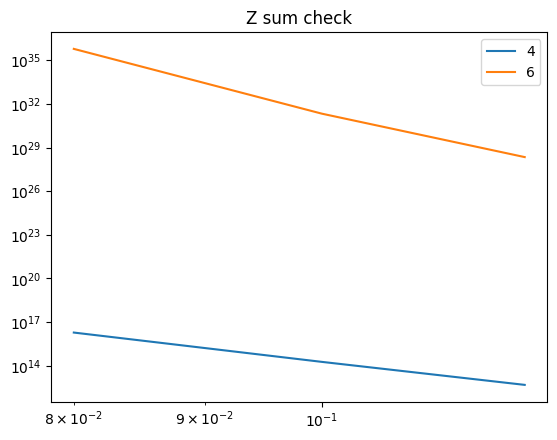

In [11]:
Z_sum_check = []

for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]

    j = 1

    res1 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_4 ])/len(free_energies_4)

    res2 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_6 ])/len(free_energies_6)
    Z_sum_check.append([res1,res2])


plt.figure
plt.plot(probabilities, Z_sum_check,label=["4","6"])
plt.title("Z sum check")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

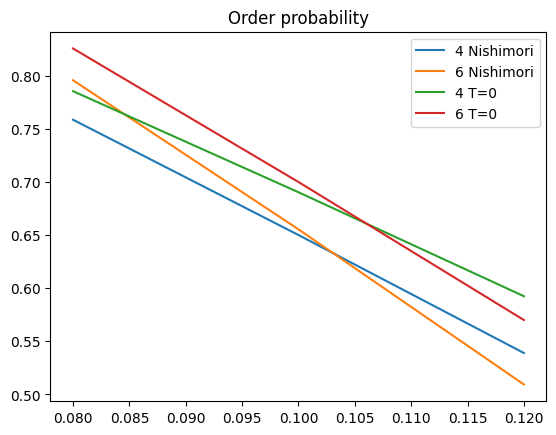

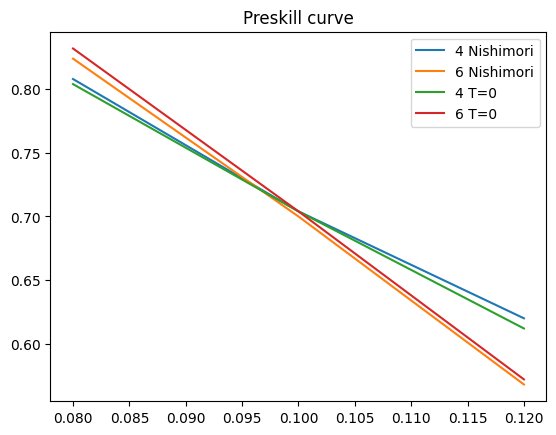

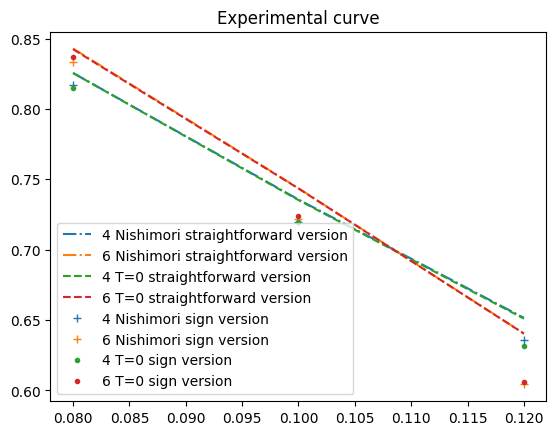

In [12]:
plt.figure
plt.plot(probabilities, order_probability,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, order_probability_T0,label=["4 T=0","6 T=0"])

plt.title("Order probability")
plt.legend()
plt.show()

plt.figure
plt.plot(probabilities, optimal_curve,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, mwpm_curve,label=["4 T=0","6 T=0"])

plt.title("Preskill curve")
plt.legend()
plt.show()

plt.figure
plt.plot(probabilities, experimental_curve_new,"-.",label=["4 Nishimori straightforward version","6 Nishimori straightforward version"])
plt.plot(probabilities, experimental_curve_new_T0,"--",label=["4 T=0 straightforward version","6 T=0 straightforward version"])
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, experimental_curve,"+",label=["4 Nishimori sign version","6 Nishimori sign version"])
plt.plot(probabilities, experimental_curve_T0,".",label=["4 T=0 sign version","6 T=0 sign version"])


plt.title("Experimental curve")
plt.legend()
plt.show()


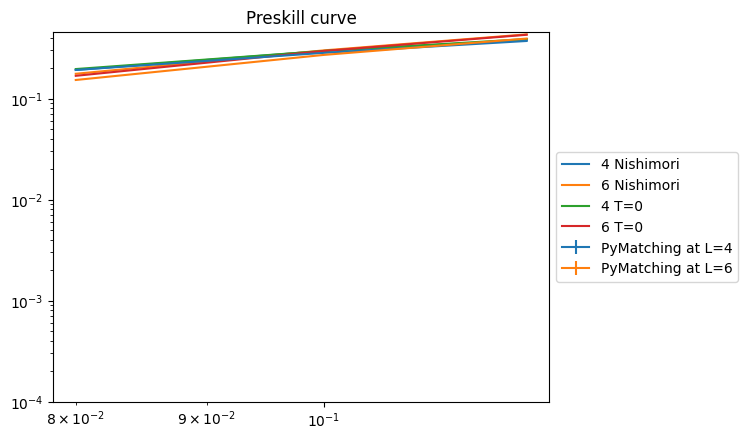

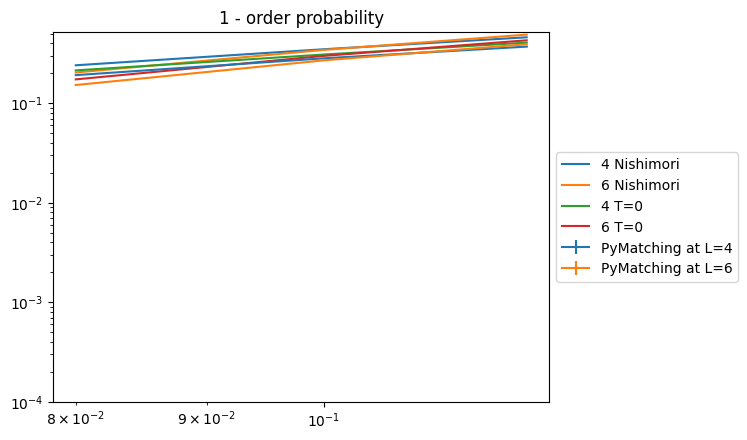

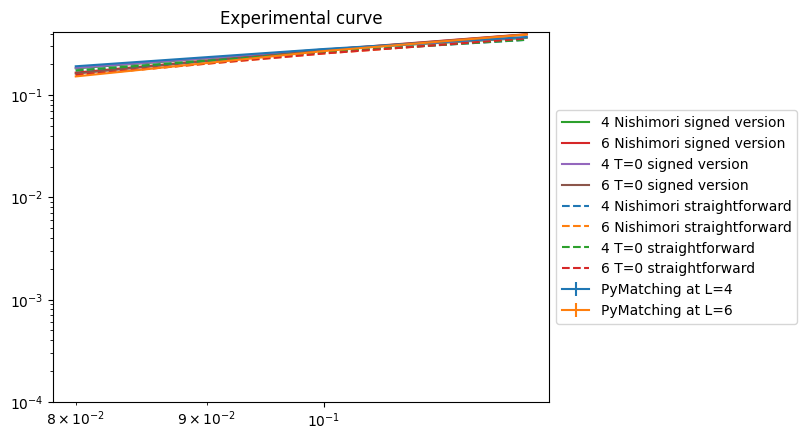

In [13]:
plt.figure

for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))

plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4 Nishimori")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6 Nishimori")
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(optimal_curve))], label= "4 T=0")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(optimal_curve))], label= "6 T=0")


plt.title("Preskill curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()



plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))

plt.gca().set_prop_cycle(None)


plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4 Nishimori")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6 Nishimori")
plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(order_probability))], label = "4 T=0")
plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(order_probability))], label = "6 T=0")


plt.title("1 - order probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))



plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],label="4 Nishimori signed version")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],label="6 Nishimori signed version")
plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],label="4 T=0 signed version")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],label="6 T=0 signed version")
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label="4 T=0 straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label="6 T=0 straightforward")


plt.title("Experimental curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()

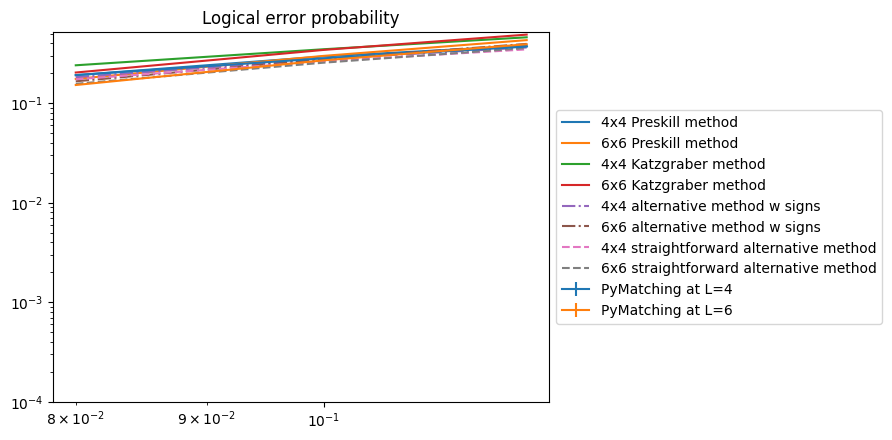

In [14]:
plt.figure

# plt.plot(probabilities, [p for p in probabilities],"--",color="black",label="Break-even")
# plt.plot(probabilities, [30*p**2 for p in probabilities],"--",color="gray",label="4 expected slope")
# plt.plot(probabilities, [150*p**3 for p in probabilities],"-.",color="gray",label="6 expected slope")


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))

plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6x6 Katzgraber method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],'-.',label="4x4 alternative method w signs")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],'-.',label="6x6 alternative method w signs")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")

plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


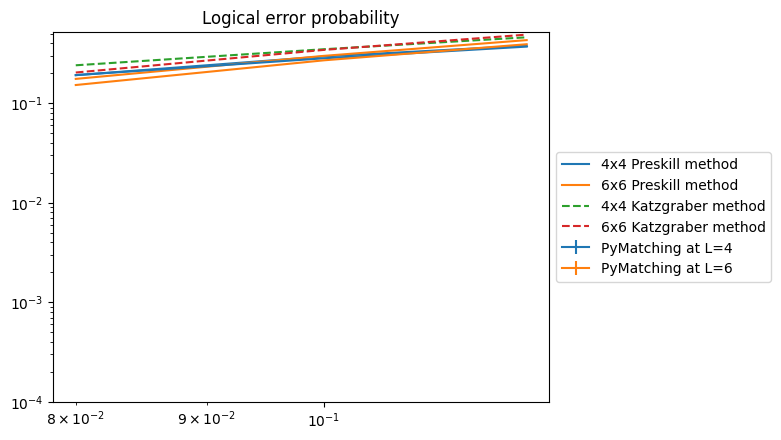

In [15]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))

plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],"--",label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],"--",label="6x6 Katzgraber method")


plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


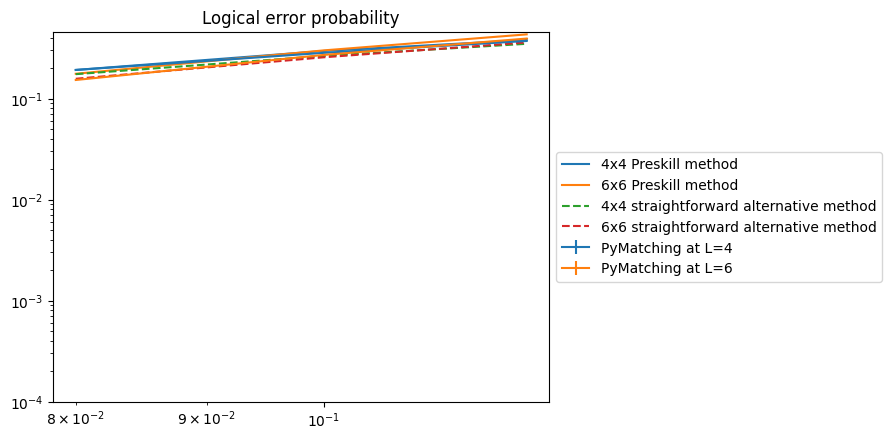

In [16]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))

plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")

plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()

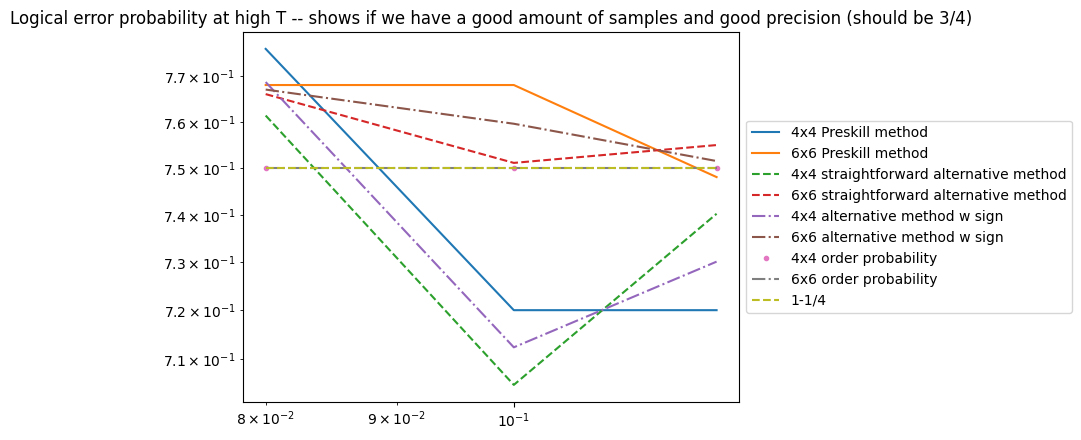

In [17]:
plt.figure


plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-Preskill_curve_highT[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-Preskill_curve_highT[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new_highT[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new_highT[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")



plt.plot(probabilities, [1-experimental_curve_highT[j][0] for j in range(len(experimental_curve))],"-.",label="4x4 alternative method w sign")
plt.plot(probabilities, [1-experimental_curve_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 alternative method w sign")


plt.plot(probabilities, [1-order_probability_highT[j][0] for j in range(len(experimental_curve))],".",label="4x4 order probability")
plt.plot(probabilities, [1-order_probability_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 order probability")

plt.plot(probabilities,[1-1/4 for j in range(len(probabilities))],"--", label="1-1/4")


plt.title("Logical error probability at high T -- shows if we have a good amount of samples and good precision (should be 3/4)")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

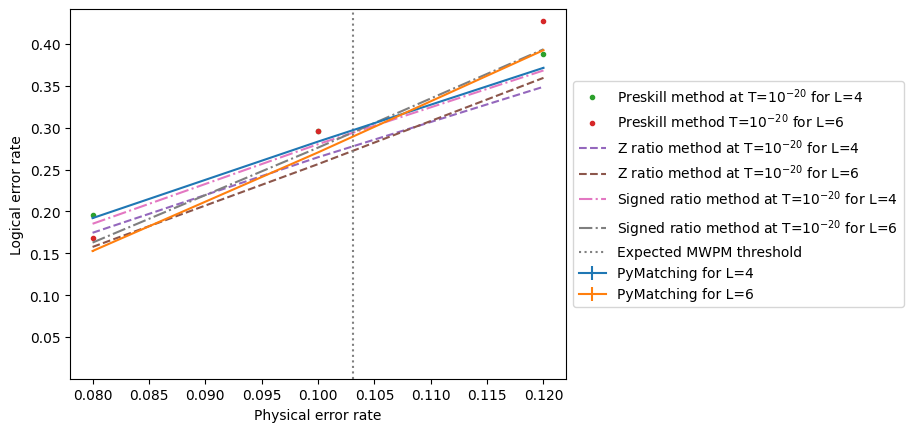

In [18]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))



plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-20}$ for L=6")





plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-20}$ for L=6")





plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],"-.",label=r"Signed ratio method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],"-.",label=r"Signed ratio method at T=$10^{-20}$ for L=6")



plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()